# Rock Paper Scissors - Pytorch Multiclass Classifier
In this workbook we illustrate multi-class image classification of the [Rock Paper Scissors dataset](https://www.kaggle.com/drgfreeman/rockpaperscissors), which is downloaded from Kaggle from the above URL. You'll need to login with your Kaggle ID to download the dataset. The data was downloaded and un-zipped to the `./data/RockPaperScissors` folder

In [1]:
# Connect to Google drive, so I can import modules from it into my workspace
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_toolkit as pyt
        MODEL_SAVE_DIR = os.path.join(pyt_path, 'model_states')
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

MODEL_SAVE_DIR = .\model_states


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torchvision import transforms 
from tensorflow.keras.preprocessing.image import *
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.8.1+cpu. GPU is NOT available


In [3]:
CLASSES = ['rock', 'paper', 'scissors']

In [4]:
def get_data(image_paths):
    images, labels = [], []

    for image_path in image_paths:
        image = load_img(image_path, target_size=(32,32), color_mode='grayscale')
        image = img_to_array(image)
        label_name = image_path.split(os.path.sep) [-2]
        label = CLASSES.index(label_name)
        label = np.array(label).astype('int32')
        images.append(image)
        labels.append(label)

        #labels = np.expand_dims(labels, axis=0)

    return np.array(images), np.array(labels)

In [5]:
file_pattern = pathlib.Path.cwd() / 'data' / 'RockPaperScissors' /  '*' / '*.png'
dataset_paths = [*glob.glob(str(file_pattern))]
random.shuffle(dataset_paths)
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (2188, 32, 32, 1) - labels.shape: (2188,)


In [6]:
dataset_paths[:10]

['C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\scissors\\TNOQ2IEy4C6LBSD1.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\rock\\SNEJ1wGU1s9Dm3I1.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\rock\\Q2rRUGWBDy47XucJ.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\rock\\zrrYLvM2uywyFwRy.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\scissors\\WtS1aLhJK2FZpcEt.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\rock\\Yzx0RwB2AFNAvC6s.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\scissors\\Egi7OpuV8V24C2LP.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\rock\\NSlKVMz6GymflBze.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-pytorch\\data\\RockPaperScissors\\paper\\3JN7OPsnxDBpcVeD.png',
 'C:\\Dev\\code\\python\\git-projects\\dl-

In [7]:
np.bincount(labels.astype('int32')), labels[:10]

(array([726, 712, 750], dtype=int64), array([2, 0, 0, 0, 2, 0, 2, 0, 1, 1]))

In [8]:
def build_model():
    net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),       

        nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),     

        nn.Flatten(),

        nn.Linear(64*2*2, 500),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(500, 3)
    )

    model = pytk.PytkModuleWrapper(net)
    # add weights to optimizer due to class imbalance
    # weights = torch.FloatTensor(class_counts) / total
    # weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(params=model.parameters(), lr=0.001)
    optimizer = optim.SGD(params=model.parameters(), lr=0.001)
    model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
    return model

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, 
                                                    random_state=SEED, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, 
                                                random_state=SEED, stratify=y_test)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

X_train.shape: (1531, 32, 32, 1) - y_train.shape: (1531,) - class dist: [508 498 525]
X_val.shape: (591, 32, 32, 1) - y_val.shape: (591,) - class dist: [196 193 202]
X_test.shape: (66, 32, 32, 1) - y_test.shape: (66,) - class dist: [22 21 23]


In [10]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [11]:
train_dataset = RPSDataset(X_train, y_train, image_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


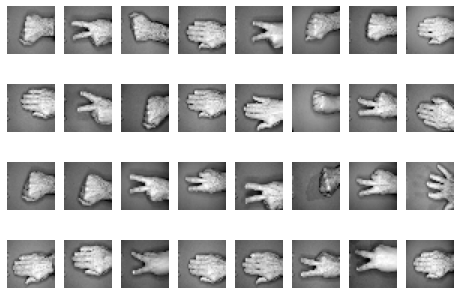

In [12]:
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = data_iter.next()
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
plt.close()

In [13]:
model = build_model()
print(model.summary((1, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             832
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         MaxPool2d-4           [-1, 32, 15, 15]               0
           Dropout-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          51,264
              ReLU-7           [-1, 64, 13, 13]               0
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10             [-1, 64, 6, 6]               0
           Conv2d-11             [-1, 64, 4, 4]         102,464
             ReLU-12             [-1, 64, 4, 4]               0
      BatchNorm2d-13             [-1, 64, 4, 4]             128
        MaxPool2d-14             [-1, 6

In [14]:
hist = model.fit_dataset(train_dataset, epochs=100, batch_size=32, 
                         validation_dataset=val_dataset)

Training on CPU...
Training on 1531 samples, cross-validating on 591 samples
Epoch (  1/100): (1531/1531) -> loss: 1.0996 - acc: 0.4198 - val_loss: 0.9854 - val_acc: 0.6784 - lr: ['0.00100000']
Epoch (  2/100): (1531/1531) -> loss: 1.0023 - acc: 0.5257 - val_loss: 0.8916 - val_acc: 0.7771 - lr: ['0.00100000']
Epoch (  3/100): (1531/1531) -> loss: 0.9196 - acc: 0.5917 - val_loss: 0.8497 - val_acc: 0.7938 - lr: ['0.00100000']
Epoch (  4/100): (1531/1531) -> loss: 0.8277 - acc: 0.6781 - val_loss: 0.8000 - val_acc: 0.8086 - lr: ['0.00100000']
Epoch (  5/100): (1531/1531) -> loss: 0.7857 - acc: 0.6968 - val_loss: 0.7368 - val_acc: 0.8135 - lr: ['0.00100000']
Epoch (  6/100): (1531/1531) -> loss: 0.7271 - acc: 0.7361 - val_loss: 0.6575 - val_acc: 0.8283 - lr: ['0.00100000']
Epoch (  7/100): (1531/1531) -> loss: 0.6469 - acc: 0.7739 - val_loss: 0.6001 - val_acc: 0.8382 - lr: ['0.00100000']
Epoch (  8/100): (1531/1531) -> loss: 0.5834 - acc: 0.8191 - val_loss: 0.5618 - val_acc: 0.8382 - lr: ['

Epoch ( 70/100): (1531/1531) -> loss: 0.0929 - acc: 0.9724 - val_loss: 0.0830 - val_acc: 0.9852 - lr: ['0.00100000']
Epoch ( 71/100): (1531/1531) -> loss: 0.0860 - acc: 0.9753 - val_loss: 0.0860 - val_acc: 0.9868 - lr: ['0.00100000']
Epoch ( 72/100): (1531/1531) -> loss: 0.0827 - acc: 0.9766 - val_loss: 0.0792 - val_acc: 0.9852 - lr: ['0.00100000']
Epoch ( 73/100): (1531/1531) -> loss: 0.0832 - acc: 0.9766 - val_loss: 0.0800 - val_acc: 0.9868 - lr: ['0.00100000']
Epoch ( 74/100): (1531/1531) -> loss: 0.0823 - acc: 0.9740 - val_loss: 0.0647 - val_acc: 0.9868 - lr: ['0.00100000']
Epoch ( 75/100): (1531/1531) -> loss: 0.0789 - acc: 0.9759 - val_loss: 0.0861 - val_acc: 0.9868 - lr: ['0.00100000']
Epoch ( 76/100): (1531/1531) -> loss: 0.0904 - acc: 0.9693 - val_loss: 0.0726 - val_acc: 0.9868 - lr: ['0.00100000']
Epoch ( 77/100): (1531/1531) -> loss: 0.0680 - acc: 0.9785 - val_loss: 0.0901 - val_acc: 0.9868 - lr: ['0.00100000']
Epoch ( 78/100): (1531/1531) -> loss: 0.0800 - acc: 0.9757 - val

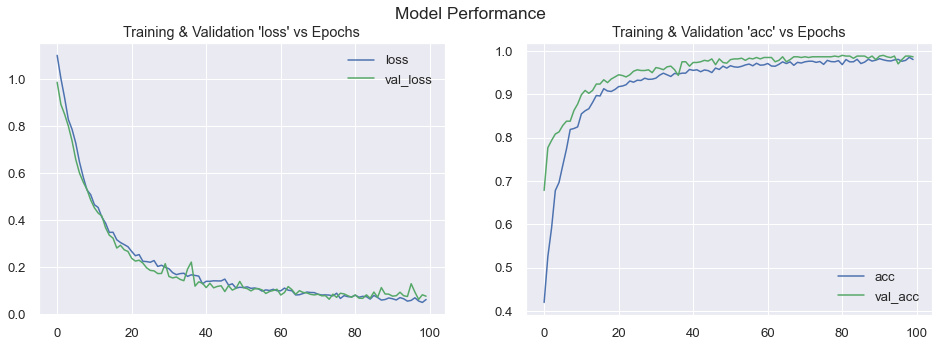

In [15]:
pytk.show_plots(hist, metric='acc', plot_title='Model Performance')

In [16]:
loss, acc = model.evaluate_dataset(train_dataset)
print(f"Training  -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(val_dataset)
print(f"Cross-val -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(test_dataset)
print(f"Testing   -> loss: {loss:.3f} - acc: {acc:.3f}")

Evaluating (1531/1531) -> loss: 0.0171 - acc: 0.9947
Training  -> loss: 0.017 - acc: 0.995
Evaluating (591/591) -> loss: 0.0748 - acc: 0.9875
Cross-val -> loss: 0.075 - acc: 0.988
Evaluating (66/66) -> loss: 0.1621 - acc: 0.9844
Testing   -> loss: 0.162 - acc: 0.984


In [17]:
model.save('./model_states/pytk_rock_paper_scissors.pt')
del model

Pytorch model saved to C:\Dev\code\python\git-projects\dl-pytorch\model_states\pytk_rock_paper_scissors.pt


In [18]:
model = build_model()
model.load('./model_states/pytk_rock_paper_scissors.pt')
print(model.summary((1, 32, 32)))

Pytorch model loaded from C:\Dev\code\python\git-projects\dl-pytorch\model_states\pytk_rock_paper_scissors.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             832
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         MaxPool2d-4           [-1, 32, 15, 15]               0
           Dropout-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          51,264
              ReLU-7           [-1, 64, 13, 13]               0
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10             [-1, 64, 6, 6]               0
           Conv2d-11             [-1, 64, 4, 4]         102,464
             ReLU-12             [-1, 64, 4, 4]          

In [19]:
probs, y_test = model.predict_dataset(test_dataset)
y_pred = np.argmax(probs, axis=1)
y_test[:20], y_pred[:20]

(array([0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 2, 2, 1, 1, 1], dtype=int64),
 array([0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 2, 2, 1, 1, 1], dtype=int64))

In [20]:
print(f"We got {(y_test == y_pred).sum()} of {len(y_test)} correct!")

We got 64 of 66 correct!


In [21]:
del model